In [1]:
from joblib import load
import sys
from Sparse_vector.sparse_vector import SparseVector
from joblib import load
from tqdm import trange
from tqdm.notebook import tqdm
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score, auc
from sklearn.metrics import precision_recall_curve

In [2]:
import urllib.request

url = "https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.chrom.sizes"
filename = "hg38.chrom.sizes"

urllib.request.urlretrieve(url, filename)
chrom_sizes_file = "hg38.chrom.sizes"

def get_chrom_sizes():
    chrom_sizes = {}
    with open(chrom_sizes_file) as f:
        for line in f:
            name, size = line.strip().split("\t")
            chrom_sizes[name] = int(size)
    return chrom_sizes
  
chr_size = get_chrom_sizes()

In [3]:
chrom_names = [f'chr{i}' for i in list(range(1, 23)) + ['X', 'Y','M']]
features = [i[:-4] for i in os.listdir('omicDC_results_Prostate/')]
groups = ['Histone','TFs']
feature_names = [i for i in features if (i.split('_')[0] in groups)]
DNA_features = {feture: load(f'omicDC_results_Prostate/{feture}.pkl')
                for feture in tqdm(feature_names)}

  0%|          | 0/193 [00:00<?, ?it/s]

In [4]:
from collections import defaultdict

result_dict = defaultdict(set)

with open("prostate.bed", "r") as bed_file:

    for line in bed_file:
        chrom, start, end = line.strip().split("\t")[:3]
        start, end = int(start), int(end)
        result_dict[chrom].update(set(range(start, end+1)))


In [5]:
win_in = []
win_out = []
width = 5000
ws = [-20*width, -10*width, -5*width, 5*width, 10*width, 20*width]

for chrm in tqdm(chrom_names):
    first_time = True
    for pos in result_dict[chrm]:  
        win_in.append([chrm, max(pos - width//2, 0), min(pos + width//2, chr_size[chrm])])
        for w in ws:
            if w < 0:
                w = abs(w)
                pos -= w
            else:
                pos += w
            interval = [min(max(pos - width//2, 0), chr_size[chrm]), max(0, min(pos + width//2, chr_size[chrm]))]
            is_in = False
            for i in range(interval[0], interval[1]+1):
                if interval[0] + i in result_dict[chrm]:
                    is_in = True
                    break
            if not is_in and interval[0] != interval[1]:
                win_out.append([chrm, interval[0], interval[1]])

  0%|          | 0/25 [00:00<?, ?it/s]

In [6]:
win_in[:10]

[['chr1', 21923389, 21928389],
 ['chr1', 223315521, 223320521],
 ['chr1', 241681988, 241686988],
 ['chr1', 241686084, 241691084],
 ['chr1', 243484232, 243489232],
 ['chr1', 176207433, 176212433],
 ['chr1', 215803470, 215808470],
 ['chr1', 241067598, 241072598],
 ['chr1', 191538770, 191543770],
 ['chr1', 224056915, 224061915]]

In [7]:
win_out[:10]

[['chr1', 21823389, 21828389],
 ['chr1', 21773389, 21778389],
 ['chr1', 21748389, 21753389],
 ['chr1', 21773389, 21778389],
 ['chr1', 21823389, 21828389],
 ['chr1', 21923389, 21928389],
 ['chr1', 223215521, 223220521],
 ['chr1', 223165521, 223170521],
 ['chr1', 223140521, 223145521],
 ['chr1', 223165521, 223170521]]

In [8]:
print(len(win_in), len(win_out))

26933 158702


In [9]:
ints_in1 = np.array(win_in)
ints_out1 = np.array(win_out)[np.random.choice(range(len(win_out)), size=len(win_in) * 2, replace=False)]

In [10]:
print(len(ints_in1), len(ints_out1))

26933 53866


In [11]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

equalized1 = [[inter[0], int(inter[1]), int(inter[2]), 1] for inter in ints_in1]
equalized0 = [[inter[0], int(inter[1]), int(inter[2]), 0] for inter in ints_out1]
equalized = np.vstack((equalized1, equalized0))

np.random.shuffle(equalized)
equalized[0:10]

array([['chr11', '122826317', '122831317', '0'],
       ['chr4', '140564477', '140569477', '0'],
       ['chr22', '30722068', '30727068', '0'],
       ['chr6', '140272320', '140277320', '0'],
       ['chr1', '2495264', '2500264', '1'],
       ['chr5', '137455599', '137460599', '1'],
       ['chr1', '77351987', '77356987', '0'],
       ['chr1', '216840137', '216845137', '1'],
       ['chr5', '90418186', '90423186', '0'],
       ['chr10', '86559850', '86564850', '0']], dtype='<U21')

In [12]:
import numpy as np
import torch
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

X = []
y = []

pbar = tqdm(total=len(equalized))

for idx in range(len(equalized)):
    pbar.update(1)
    inter = equalized[idx]
    chrom = inter[0]
    begin = int(inter[1])
    end = int(inter[2])
    target = int(inter[3])
    feature_matr = []
    for feature in feature_names:
        source = DNA_features[feature]
        feature_matr.append(source[chrom][begin:end].mean())

    if len(feature_matr) > 0:
        new_row = np.hstack(np.array(feature_matr).T).astype(np.float32)
        X.append(new_row)
        y.append(target)
    else:
        continue 

pbar.close()

100%|█████████████████████████████████████████████████████████████████████████████████| 80799/80799 [08:07<00:00, 165.85it/s]


In [13]:
X = np.array(X)

scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)
X = torch.tensor(X_normalized, dtype=torch.float)
y = torch.tensor(y, dtype=torch.int64)

In [14]:
X = np.array(X)
X

array([[-0.1651813 , -0.07125886, -0.05122381, ..., -0.05283415,
        -0.11029427, -0.07703236],
       [-0.1651813 , -0.07125886, -0.05122381, ..., -0.05283415,
        -0.11029427, -0.07703236],
       [-0.1651813 , -0.07125886, -0.05122381, ..., -0.05283415,
        -0.11029427, -0.07703236],
       ...,
       [-0.1651813 , -0.07125886, -0.05122381, ..., -0.05283415,
        -0.11029427, -0.07703236],
       [-0.1651813 , -0.07125886, -0.05122381, ..., -0.05283415,
        -0.11029427, -0.07703236],
       [-0.1651813 , -0.07125886, -0.05122381, ..., -0.05283415,
        -0.11029427, -0.07703236]], dtype=float32)

In [15]:
X.shape

(80799, 193)

In [16]:
y

tensor([0, 0, 0,  ..., 1, 0, 0])

In [17]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = np.array(y_train)
y_test = np.array(y_test)

X_train = tf.keras.utils.normalize(X_train, axis=1)
X_test = tf.keras.utils.normalize(X_test, axis=1)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

model = Sequential()
model.add(SimpleRNN(units=64, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

roc_auc = roc_auc_score(y_test, y_pred)
print("ROC-AUC score: {:.4f}".format(roc_auc))


2023-05-16 00:03:14.375285: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-16 00:03:15.099398: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Epoch 1/10
2020/2020 [==============================] - 27s 13ms/step - loss: 0.6374 - accuracy: 0.6667 - val_loss: 0.6387 - val_accuracy: 0.6649
Epoch 2/10
2020/2020 [==============================] - 26s 13ms/step - loss: 0.6362 - accuracy: 0.6671 - val_loss: 0.6375 - val_accuracy: 0.6649
Epoch 3/10
2020/2020 [==============================] - 26s 13ms/step - loss: 0.6359 - accuracy: 0.6671 - val_loss: 0.6383 - val_accuracy: 0.6649
Epoch 4/10
2020/2020 [==============================] - 26s 13ms/step - loss: 0.6359 - accuracy: 0.6671 - val_loss: 0.6395 - val_accuracy: 0.6649
Epoch 5/10
2020/2020 [==============================] - 26s 13ms/step - loss: 0.6356 - accuracy: 0.6672 - val_loss: 0.6370 - val_accuracy: 0.6650
Epoch 6/10
2020/2020 [==============================] - 26s 13ms/step - loss: 0.6353 - accuracy: 0.6679 - val_loss: 0.6371 - val_accuracy: 0.6662
Epoch 7/10
2020/2020 [==============================] - 26s 13ms/step - loss: 0.6352 - accuracy: 0.6682 - val_loss: 0.6366 -

In [21]:
from copy import deepcopy
X_copy = deepcopy(X)
y_copy = deepcopy(y)

In [22]:
X = X_copy
y = y_copy

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

input_size = X.shape[1]
hidden_size = 128
num_layers = 2
num_classes = 2
num_epochs = 20
batch_size = 64
learning_rate = 0.001

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 16
X_train = torch.tensor(X_train, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

train_data = torch.utils.data.TensorDataset(X_train, y_train)
data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

model = LSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_values = []
train_f1_values = []
train_roc_auc_values = []
train_pr_auc_values = []
test_loss_values = []
test_f1_values = []
test_roc_auc_values = []
test_pr_auc_values = []

for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        true_labels = []
        predicted_labels = []
        predicted_probs = []

        for i, (inputs, labels) in enumerate(data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            probs = nn.functional.softmax(outputs, dim=1)
        predicted_probs.extend(probs.cpu().detach().numpy()[:, 1])
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

        epoch_loss /= len(data_loader)
        f1 = f1_score(true_labels, predicted_labels, average='weighted')
        if np.array(true_labels).std() == 0:
            roc_auc = 0
        else:
            roc_auc = roc_auc_score(true_labels, predicted_probs)
        pr, re, _ = precision_recall_curve(true_labels, predicted_probs)
        pr_auc = auc(re, pr)

        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)
            probs = nn.functional.softmax(test_outputs, dim=1)
            test_predicted_probs = probs.cpu().detach().numpy()[:, 1]
            _, test_preds = torch.max(test_outputs, 1)
            test_true_labels = y_test.cpu().numpy()
            test_f1 = f1_score(test_true_labels, test_preds.cpu().numpy(), average='weighted')
            test_roc_auc = roc_auc_score(test_true_labels, test_predicted_probs)
            test_pr, test_re, _ = precision_recall_curve(test_true_labels, test_predicted_probs)
            test_pr_auc = auc(test_re, test_pr)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train F1-score: {f1:.4f}, Train ROC-AUC: {roc_auc:.4f}, Train PR-AUC: {pr_auc:.4f}, Test Loss: {test_loss:.4f}, Test F1-score: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc:.4f}, Test PR-AUC: {test_pr_auc:.4f}')

        train_loss_values.append(epoch_loss)
        train_f1_values.append(f1)
        train_roc_auc_values.append(roc_auc)
        train_pr_auc_values.append(pr_auc)
        test_loss_values.append(test_loss.item())
        test_f1_values.append(test_f1)
        test_roc_auc_values.append(test_roc_auc)
        test_pr_auc_values.append(test_pr_auc)


/tmp/ipykernel_29655/3757297636.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long).to(device)
/tmp/ipykernel_29655/3757297636.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.long).to(device)


Epoch [1/20], Train Loss: 0.6353, Train F1-score: 0.3710, Train ROC-AUC: 0.5179, Train PR-AUC: 0.4790, Test Loss: 0.6357, Test F1-score: 0.5395, Test ROC-AUC: 0.5197, Test PR-AUC: 0.3635
Epoch [2/20], Train Loss: 0.6323, Train F1-score: 0.2970, Train ROC-AUC: 0.6250, Train PR-AUC: 0.7687, Test Loss: 0.6372, Test F1-score: 0.5430, Test ROC-AUC: 0.5205, Test PR-AUC: 0.3639
Epoch [3/20], Train Loss: 0.6305, Train F1-score: 0.7111, Train ROC-AUC: 0.5556, Train PR-AUC: 0.4794, Test Loss: 0.6363, Test F1-score: 0.5467, Test ROC-AUC: 0.5256, Test PR-AUC: 0.3669
Epoch [4/20], Train Loss: 0.6278, Train F1-score: 0.6769, Train ROC-AUC: 0.3056, Train PR-AUC: 0.1388, Test Loss: 0.6376, Test F1-score: 0.5463, Test ROC-AUC: 0.5190, Test PR-AUC: 0.3612
Epoch [5/20], Train Loss: 0.6234, Train F1-score: 0.4500, Train ROC-AUC: 0.2222, Train PR-AUC: 0.2667, Test Loss: 0.6419, Test F1-score: 0.5488, Test ROC-AUC: 0.5187, Test PR-AUC: 0.3588
Epoch [6/20], Train Loss: 0.6181, Train F1-score: 0.3710, Train R

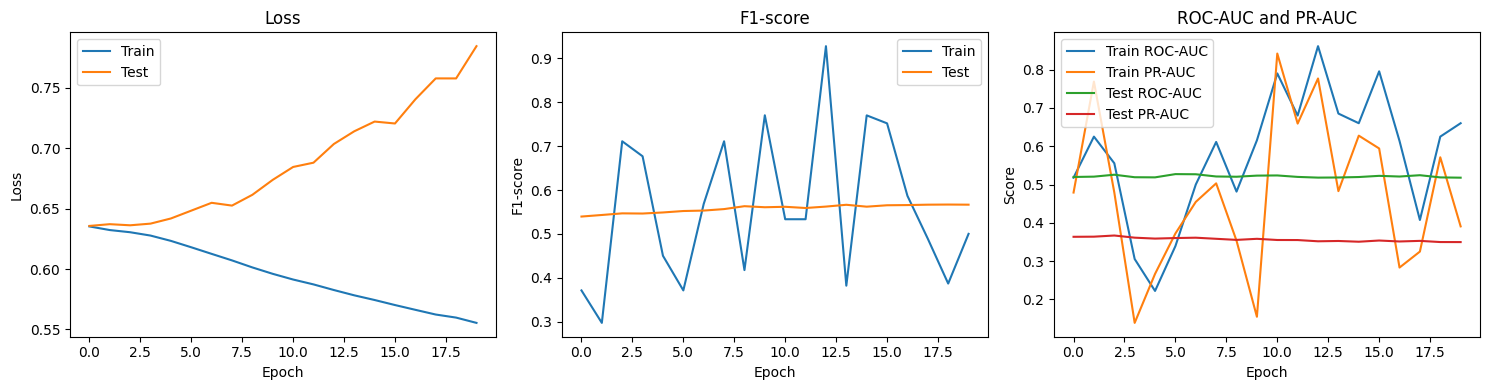

In [25]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.plot(train_loss_values, label="Train")
ax1.plot(test_loss_values, label="Test")
ax1.legend()

ax2.set_title("F1-score")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("F1-score")
ax2.plot(train_f1_values, label="Train")
ax2.plot(test_f1_values, label="Test")
ax2.legend()

ax3.set_title("ROC-AUC and PR-AUC")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Score")
ax3.plot(train_roc_auc_values, label="Train ROC-AUC")
ax3.plot(train_pr_auc_values, label="Train PR-AUC")
ax3.plot(test_roc_auc_values, label="Test ROC-AUC")
ax3.plot(test_pr_auc_values, label="Test PR-AUC")
ax3.legend()

fig.tight_layout()
plt.show()

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate=0.5):
        super(BiLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        x = self.dropout(x)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        return out.squeeze(1)
input_size = X.shape[1]
hidden_size = 128
num_layers = 2
num_classes = 1
num_epochs = 20
batch_size = 64
learning_rate = 0.0001

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train = torch.tensor(X_train, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_train = torch.tensor(y_train, dtype=torch.float).to(device)
X_test = torch.tensor(X_test, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_test = torch.tensor(y_test, dtype=torch.float).to(device)

train_data = torch.utils.data.TensorDataset(X_train, y_train)
data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)


model = BiLSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_values = []
train_f1_values = []
train_roc_auc_values = []
train_pr_auc_values = []
test_loss_values = []
test_f1_values = []
test_roc_auc_values = []
test_pr_auc_values = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    true_labels = []
    predicted_labels = []
    predicted_probs = []

    for i, (inputs, labels) in enumerate(data_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        probs = torch.sigmoid(outputs).cpu().detach().numpy()
        predicted_probs.extend(probs)
        preds = (probs > 0.5).astype(int)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds)

    epoch_loss /= len(data_loader)
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    roc_auc = roc_auc_score(true_labels, predicted_probs)
    pr, re, _ = precision_recall_curve(true_labels, predicted_probs)
    pr_auc = auc(re, pr)

    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        probs = torch.sigmoid(test_outputs).cpu().detach().numpy()
        test_predicted_probs = probs
        test_preds = (probs > 0.5).astype(int)
        test_true_labels = y_test.cpu().numpy()
        test_f1 = f1_score(test_true_labels, test_preds, average='weighted')
        test_roc_auc = roc_auc_score(test_true_labels, test_predicted_probs)
        test_pr, test_re, _ = precision_recall_curve(test_true_labels, test_predicted_probs)
        test_pr_auc = auc(test_re, test_pr)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train F1-score: {f1:.4f}, Train ROC-AUC: {roc_auc:.4f}, Train PR-AUC: {pr_auc:.4f}, Test Loss: {test_loss:.4f}, Test F1-score: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc:.4f}, Test PR-AUC: {test_pr_auc:.4f}')

    train_loss_values.append(epoch_loss)
    train_f1_values.append(f1)
    train_roc_auc_values.append(roc_auc)
    train_pr_auc_values.append(pr_auc)
    test_loss_values.append(test_loss.item())
    test_f1_values.append(test_f1)
    test_roc_auc_values.append(test_roc_auc)
    test_pr_auc_values.append(test_pr_auc)



/tmp/ipykernel_29655/1626131257.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float).to(device)  # Изменение: тип данных float
/tmp/ipykernel_29655/1626131257.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float).to(device)  # Изменение: тип данных float


Epoch [1/20], Train Loss: 0.6454, Train F1-score: 0.5641, Train ROC-AUC: 0.5126, Train PR-AUC: 0.3503, Test Loss: 0.6369, Test F1-score: 0.5406, Test ROC-AUC: 0.5144, Test PR-AUC: 0.3569
Epoch [2/20], Train Loss: 0.6348, Train F1-score: 0.5440, Train ROC-AUC: 0.5192, Train PR-AUC: 0.3615, Test Loss: 0.6360, Test F1-score: 0.5401, Test ROC-AUC: 0.5238, Test PR-AUC: 0.3634
Epoch [3/20], Train Loss: 0.6340, Train F1-score: 0.5449, Train ROC-AUC: 0.5213, Train PR-AUC: 0.3666, Test Loss: 0.6356, Test F1-score: 0.5403, Test ROC-AUC: 0.5225, Test PR-AUC: 0.3627
Epoch [4/20], Train Loss: 0.6335, Train F1-score: 0.5452, Train ROC-AUC: 0.5251, Train PR-AUC: 0.3703, Test Loss: 0.6356, Test F1-score: 0.5405, Test ROC-AUC: 0.5233, Test PR-AUC: 0.3646
Epoch [5/20], Train Loss: 0.6336, Train F1-score: 0.5459, Train ROC-AUC: 0.5235, Train PR-AUC: 0.3679, Test Loss: 0.6355, Test F1-score: 0.5408, Test ROC-AUC: 0.5241, Test PR-AUC: 0.3660
Epoch [6/20], Train Loss: 0.6329, Train F1-score: 0.5461, Train R

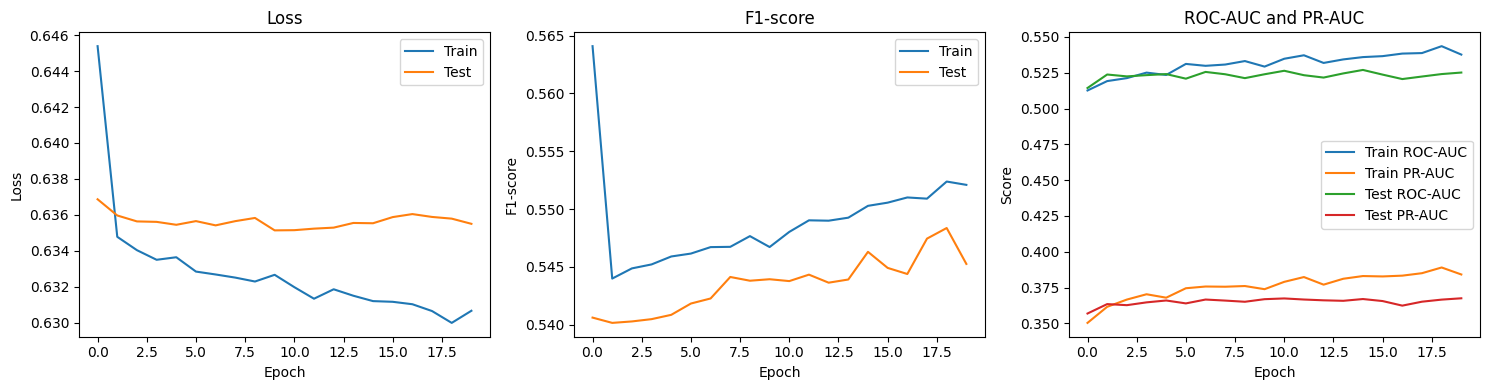

In [27]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.plot(train_loss_values, label="Train")
ax1.plot(test_loss_values, label="Test")
ax1.legend()

ax2.set_title("F1-score")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("F1-score")
ax2.plot(train_f1_values, label="Train")
ax2.plot(test_f1_values, label="Test")
ax2.legend()

ax3.set_title("ROC-AUC and PR-AUC")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Score")
ax3.plot(train_roc_auc_values, label="Train ROC-AUC")
ax3.plot(train_pr_auc_values, label="Train PR-AUC")
ax3.plot(test_roc_auc_values, label="Test ROC-AUC")
ax3.plot(test_pr_auc_values, label="Test PR-AUC")
ax3.legend()

fig.tight_layout()
plt.show()

In [28]:
from sklearn.metrics import accuracy_score
def permutation_importance(model, X_test, y_test, metric, feature_names):
    base_score = metric(y_test.cpu().numpy(), (torch.sigmoid(model(X_test)) > 0.5).cpu().numpy().astype(int))
    feature_importances = []
    X_test_permuted = X_test.clone()
    for i in range(X_test.shape[-1]):
        np.random.shuffle(X_test_permuted[:, :, i].cpu().numpy())
        score_permuted = metric(y_test.cpu().numpy(), (torch.sigmoid(model(X_test_permuted)) > 0.5).cpu().numpy().astype(int))
        feature_importances.append(base_score - score_permuted)
        X_test_permuted = X_test.clone() 
    
    feature_importance_dict = {name: importance for name, importance in zip(feature_names, feature_importances)}
    sorted_importances = sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)
    return sorted_importances

feat_names = feature_names

sorted_feature_importances = permutation_importance(model, X_test, y_test, accuracy_score, feat_names)

for name, imp in sorted_feature_importances:
    print(f'Feature {name} importance: {imp}')


Feature Histone_H3K9me2 importance: 0.0017945544554456294
Feature TFs_LMNA importance: 0.0008663366336634226
Feature TFs_MEN1 importance: 0.0008663366336634226
Feature TFs_WDR5 importance: 0.0008663366336634226
Feature TFs_EWSR1 importance: 0.0007425742574257432
Feature TFs_LMNB1 importance: 0.000680693069306959
Feature TFs_SMARCA5 importance: 0.0004950495049504955
Feature TFs_WDHD1 importance: 0.0004331683168317113
Feature TFs_MAPK1 importance: 0.00037128712871292713
Feature Histone_H3K27ac importance: 0.00030940594059414295
Feature Histone_H3K27me3 importance: 0.00030940594059414295
Feature TFs_ETV1 importance: 0.00030940594059414295
Feature TFs_MGA importance: 0.00030940594059414295
Feature TFs_NANOG importance: 0.00030940594059414295
Feature TFs_RTF1 importance: 0.00030940594059414295
Feature TFs_ZFX importance: 0.00030940594059414295
Feature Histone_H2A.Z importance: 0.00024752475247524774
Feature Histone_H2AK119Ub importance: 0.00024752475247524774
Feature TFs_FOXM1 importance: 0

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import torch.nn.functional as F

class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate=0.5):
        super(BiLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        x = self.dropout(x)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        return out


input_size = X.shape[1]
hidden_size = 128
num_layers = 2
num_classes = 2
num_epochs = 20
batch_size = 64
learning_rate = 0.001

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 16
X_train = torch.tensor(X_train, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)


train_data = torch.utils.data.TensorDataset(X_train, y_train)
data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

model = BiLSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_values = []
train_f1_values = []
train_roc_auc_values = []
train_pr_auc_values = []
test_loss_values = []
test_f1_values = []
test_roc_auc_values = []
test_pr_auc_values = []

for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        true_labels = []
        predicted_labels = []
        predicted_probs = []

        for i, (inputs, labels) in enumerate(data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            probs = nn.functional.softmax(outputs, dim=1)
        predicted_probs.extend(probs.cpu().detach().numpy()[:, 1])
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

        epoch_loss /= len(data_loader)
        f1 = f1_score(true_labels, predicted_labels, average='weighted')
        roc_auc = roc_auc_score(true_labels, predicted_probs)
        pr, re, _ = precision_recall_curve(true_labels, predicted_probs)
        pr_auc = auc(re, pr)

        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)
            probs = nn.functional.softmax(test_outputs, dim=1)
            test_predicted_probs = probs.cpu().detach().numpy()[:, 1]
            _, test_preds = torch.max(test_outputs, 1)
            test_true_labels = y_test.cpu().numpy()
            test_f1 = f1_score(test_true_labels, test_preds.cpu().numpy(), average='weighted')
            test_roc_auc = roc_auc_score(test_true_labels, test_predicted_probs)
            test_pr, test_re, _ = precision_recall_curve(test_true_labels, test_predicted_probs)
            test_pr_auc = auc(test_re, test_pr)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train F1-score: {f1:.4f}, Train ROC-AUC: {roc_auc:.4f}, Train PR-AUC: {pr_auc:.4f}, Test Loss: {test_loss:.4f}, Test F1-score: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc:.4f}, Test PR-AUC: {test_pr_auc:.4f}')

        train_loss_values.append(epoch_loss)
        train_f1_values.append(f1)
        train_roc_auc_values.append(roc_auc)
        train_pr_auc_values.append(pr_auc)
        test_loss_values.append(test_loss.item())
        test_f1_values.append(test_f1)
        test_roc_auc_values.append(test_roc_auc)
        test_pr_auc_values.append(test_pr_auc)


/tmp/ipykernel_29655/528756788.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long).to(device)
/tmp/ipykernel_29655/528756788.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.long).to(device)


Epoch [1/20], Train Loss: 0.6371, Train F1-score: 0.8048, Train ROC-AUC: 0.0769, Train PR-AUC: 0.0742, Test Loss: 0.6360, Test F1-score: 0.5403, Test ROC-AUC: 0.5227, Test PR-AUC: 0.3626
Epoch [2/20], Train Loss: 0.6351, Train F1-score: 0.3710, Train ROC-AUC: 0.5000, Train PR-AUC: 0.4251, Test Loss: 0.6364, Test F1-score: 0.5405, Test ROC-AUC: 0.5135, Test PR-AUC: 0.3571
Epoch [3/20], Train Loss: 0.6346, Train F1-score: 0.9011, Train ROC-AUC: 1.0000, Train PR-AUC: 1.0000, Test Loss: 0.6374, Test F1-score: 0.5356, Test ROC-AUC: 0.5203, Test PR-AUC: 0.3602
Epoch [4/20], Train Loss: 0.6345, Train F1-score: 0.6205, Train ROC-AUC: 0.6591, Train PR-AUC: 0.5191, Test Loss: 0.6359, Test F1-score: 0.5379, Test ROC-AUC: 0.5221, Test PR-AUC: 0.3654
Epoch [5/20], Train Loss: 0.6338, Train F1-score: 0.5045, Train ROC-AUC: 0.5357, Train PR-AUC: 0.5362, Test Loss: 0.6357, Test F1-score: 0.5417, Test ROC-AUC: 0.5191, Test PR-AUC: 0.3635
Epoch [6/20], Train Loss: 0.6334, Train F1-score: 0.3710, Train R

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score
from torch.utils.data import DataLoader, TensorDataset

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        out = self.sigmoid(out)
        return out

input_size = X.shape[1]
hidden_size = 128
num_layers = 2
num_classes = 2
num_epochs = 20
batch_size = 64
learning_rate = 0.001

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 16
X_train = torch.tensor(X_train, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)


train_data = torch.utils.data.TensorDataset(X_train, y_train)
data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

model = LSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_values = []
train_f1_values = []
train_roc_auc_values = []
train_pr_auc_values = []
test_loss_values = []
test_f1_values = []
test_roc_auc_values = []
test_pr_auc_values = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    true_labels = []
    predicted_labels = []
    predicted_probs = []

    for i, (inputs, labels) in enumerate(data_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        preds = (outputs[:, 1] > 0.5).long()

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

        softmax = nn.Softmax(dim=1)
        probs = softmax(outputs)
        predicted_probs.extend(probs[:, 1].detach().cpu().numpy())

    epoch_loss /= len(data_loader)
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    roc_auc = roc_auc_score(true_labels, predicted_probs)
    pr_auc = average_precision_score(true_labels, predicted_probs)

    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_probs = softmax(test_outputs)
        test_preds = (test_probs[:, 1] > 0.5).long()
        test_f1 = f1_score(y_test.cpu().numpy(), test_preds.cpu().numpy(), average='weighted')
        softmax = nn.Softmax(dim=1)
        test_probs = softmax(test_outputs)
        test_roc_auc = roc_auc_score(y_test.cpu().numpy(), test_probs[:, 1].cpu().numpy())
        test_pr_auc = average_precision_score(y_test.cpu().numpy(), test_probs[:, 1].cpu().numpy())

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train F1-score: {f1:.4f}, Train ROC-AUC: {roc_auc:.4f}, Train PR-AUC: {pr_auc:.4f}, Test Loss: {test_loss:.4f}, Test F1-score: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc:.4f}, Test PR-AUC: {test_pr_auc:.4f}')

    train_loss_values.append(epoch_loss)
    train_f1_values.append(f1)
    train_roc_auc_values.append(roc_auc)
    train_pr_auc_values.append(pr_auc)
    test_loss_values.append(test_loss.item())
    test_f1_values.append(test_f1)
    test_roc_auc_values.append(test_roc_auc)
    test_pr_auc_values.append(test_pr_auc)


/tmp/ipykernel_29655/1862407589.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long).to(device)
/tmp/ipykernel_29655/1862407589.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.long).to(device)


Epoch [1/20], Train Loss: 0.6347, Train F1-score: 0.5453, Train ROC-AUC: 0.5203, Train PR-AUC: 0.3618, Test Loss: 0.6356, Test F1-score: 0.5434, Test ROC-AUC: 0.5228, Test PR-AUC: 0.3676
Epoch [2/20], Train Loss: 0.6321, Train F1-score: 0.5501, Train ROC-AUC: 0.5337, Train PR-AUC: 0.3784, Test Loss: 0.6364, Test F1-score: 0.5430, Test ROC-AUC: 0.5248, Test PR-AUC: 0.3669
Epoch [3/20], Train Loss: 0.6305, Train F1-score: 0.5564, Train ROC-AUC: 0.5408, Train PR-AUC: 0.3880, Test Loss: 0.6370, Test F1-score: 0.5495, Test ROC-AUC: 0.5259, Test PR-AUC: 0.3682
Epoch [4/20], Train Loss: 0.6283, Train F1-score: 0.5647, Train ROC-AUC: 0.5503, Train PR-AUC: 0.4001, Test Loss: 0.6372, Test F1-score: 0.5483, Test ROC-AUC: 0.5269, Test PR-AUC: 0.3685
Epoch [5/20], Train Loss: 0.6259, Train F1-score: 0.5709, Train ROC-AUC: 0.5595, Train PR-AUC: 0.4113, Test Loss: 0.6387, Test F1-score: 0.5515, Test ROC-AUC: 0.5196, Test PR-AUC: 0.3636
Epoch [6/20], Train Loss: 0.6230, Train F1-score: 0.5786, Train R

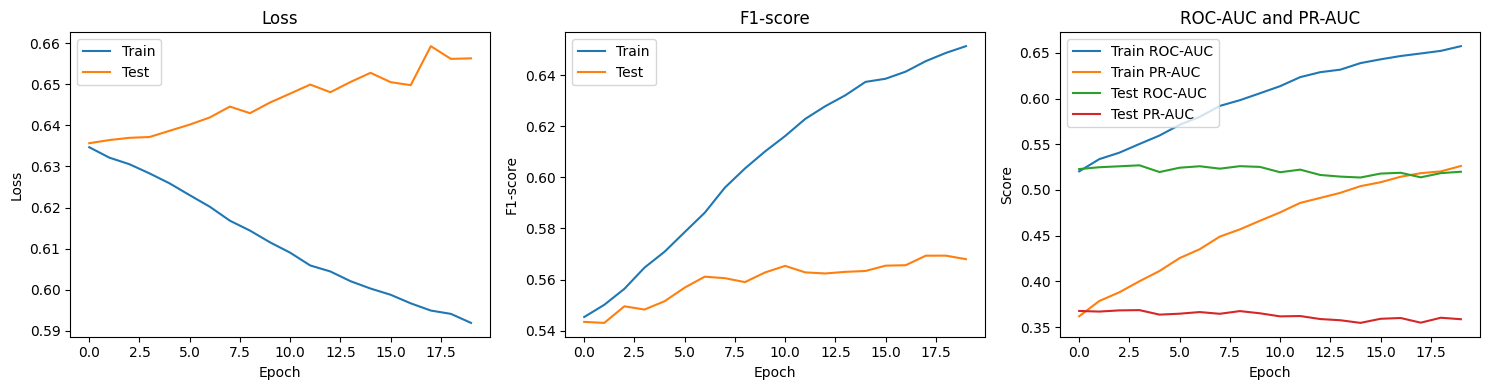

In [31]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.plot(train_loss_values, label="Train")
ax1.plot(test_loss_values, label="Test")
ax1.legend()

ax2.set_title("F1-score")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("F1-score")
ax2.plot(train_f1_values, label="Train")
ax2.plot(test_f1_values, label="Test")
ax2.legend()

ax3.set_title("ROC-AUC and PR-AUC")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Score")
ax3.plot(train_roc_auc_values, label="Train ROC-AUC")
ax3.plot(train_pr_auc_values, label="Train PR-AUC")
ax3.plot(test_roc_auc_values, label="Test ROC-AUC")
ax3.plot(test_pr_auc_values, label="Test PR-AUC")
ax3.legend()

fig.tight_layout()
plt.show()

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score
from torch.utils.data import DataLoader, TensorDataset

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_prob):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(dropout_prob)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        out = self.sigmoid(out)
        return out.squeeze()

input_size = X.shape[1]
hidden_size = 128
num_layers = 2
num_epochs = 30
batch_size = 64
learning_rate = 0.001

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 16
X_train = torch.tensor(X_train, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_train = torch.tensor(y_train, dtype=torch.float).to(device)
X_test = torch.tensor(X_test, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_test = torch.tensor(y_test, dtype=torch.float).to(device)

dropout_prob = 0.5
train_data = torch.utils.data.TensorDataset(X_train, y_train)
data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

model = LSTMModel(input_size, hidden_size, num_layers, dropout_prob).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_values = []
train_f1_values = []
train_roc_auc_values = []
train_pr_auc_values = []
test_loss_values = []
test_f1_values = []
test_roc_auc_values = []
test_pr_auc_values = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    true_labels = []
    predicted_labels = []
    predicted_probs = []

    for i, (inputs, labels) in enumerate(data_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        preds = (outputs > 0.5).float()

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())
        predicted_probs.extend(outputs.detach().cpu().numpy())

    epoch_loss /= len(data_loader)
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    roc_auc = roc_auc_score(true_labels, predicted_probs)
    pr_auc = average_precision_score(true_labels, predicted_probs)

    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_preds = (test_outputs > 0.5).float()
        test_f1 = f1_score(y_test.cpu().numpy(), test_preds.cpu().numpy(), average='weighted')

        test_roc_auc = roc_auc_score(y_test.cpu().numpy(), test_outputs.cpu().numpy())
        test_pr_auc = average_precision_score(y_test.cpu().numpy(), test_outputs.cpu().numpy())

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train F1-score: {f1:.4f}, Train ROC-AUC: {roc_auc:.4f}, Train PR-AUC: {pr_auc:.4f}, Test Loss: {test_loss:.4f}, Test F1-score: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc:.4f}, Test PR-AUC: {test_pr_auc:.4f}')

    train_loss_values.append(epoch_loss)
    train_f1_values.append(f1)
    train_roc_auc_values.append(roc_auc)
    train_pr_auc_values.append(pr_auc)
    test_loss_values.append(test_loss.item())
    test_f1_values.append(test_f1)
    test_roc_auc_values.append(test_roc_auc)
    test_pr_auc_values.append(test_pr_auc)


/tmp/ipykernel_29655/792856689.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float).to(device)
/tmp/ipykernel_29655/792856689.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float).to(device)


Epoch [1/30], Train Loss: 0.6357, Train F1-score: 0.5436, Train ROC-AUC: 0.5195, Train PR-AUC: 0.3597, Test Loss: 0.6357, Test F1-score: 0.5409, Test ROC-AUC: 0.5215, Test PR-AUC: 0.3653
Epoch [2/30], Train Loss: 0.6334, Train F1-score: 0.5469, Train ROC-AUC: 0.5292, Train PR-AUC: 0.3724, Test Loss: 0.6363, Test F1-score: 0.5430, Test ROC-AUC: 0.5169, Test PR-AUC: 0.3635
Epoch [3/30], Train Loss: 0.6323, Train F1-score: 0.5496, Train ROC-AUC: 0.5350, Train PR-AUC: 0.3800, Test Loss: 0.6367, Test F1-score: 0.5427, Test ROC-AUC: 0.5206, Test PR-AUC: 0.3615
Epoch [4/30], Train Loss: 0.6312, Train F1-score: 0.5527, Train ROC-AUC: 0.5383, Train PR-AUC: 0.3844, Test Loss: 0.6370, Test F1-score: 0.5426, Test ROC-AUC: 0.5223, Test PR-AUC: 0.3625
Epoch [5/30], Train Loss: 0.6300, Train F1-score: 0.5531, Train ROC-AUC: 0.5468, Train PR-AUC: 0.3906, Test Loss: 0.6372, Test F1-score: 0.5459, Test ROC-AUC: 0.5228, Test PR-AUC: 0.3632
Epoch [6/30], Train Loss: 0.6286, Train F1-score: 0.5587, Train R

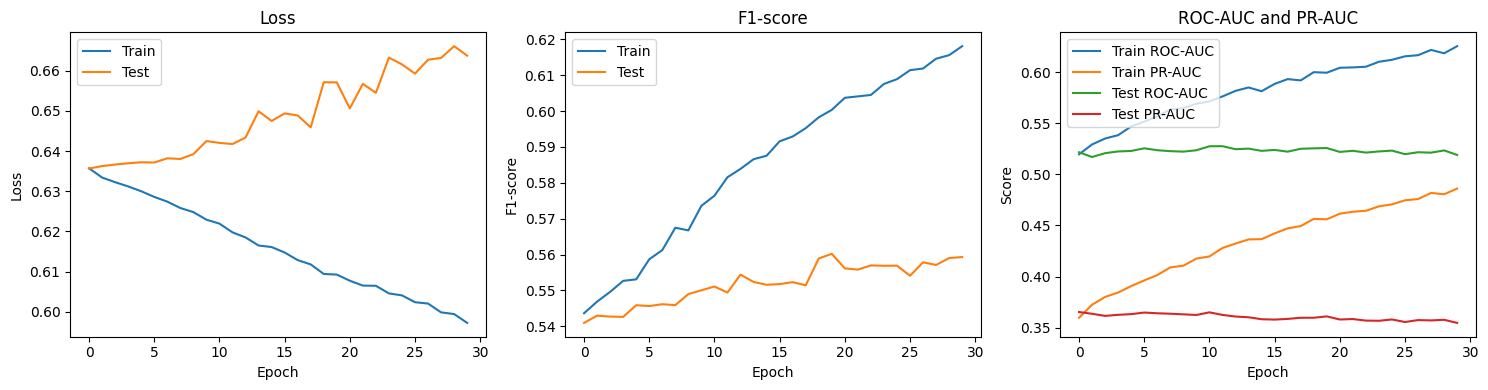

In [33]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.plot(train_loss_values, label="Train")
ax1.plot(test_loss_values, label="Test")
ax1.legend()

ax2.set_title("F1-score")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("F1-score")
ax2.plot(train_f1_values, label="Train")
ax2.plot(test_f1_values, label="Test")
ax2.legend()

ax3.set_title("ROC-AUC and PR-AUC")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Score")
ax3.plot(train_roc_auc_values, label="Train ROC-AUC")
ax3.plot(train_pr_auc_values, label="Train PR-AUC")
ax3.plot(test_roc_auc_values, label="Test ROC-AUC")
ax3.plot(test_pr_auc_values, label="Test PR-AUC")
ax3.legend()

fig.tight_layout()
plt.show()

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, roc_auc_score, auc
from sklearn.metrics import precision_recall_curve
from torch.utils.data import DataLoader, TensorDataset

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.5, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

input_size = X.shape[1]
hidden_size = 256
num_layers = 3
num_classes = 2
num_epochs = 20
batch_size = 64
learning_rate = 0.001

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 16
X_train = torch.tensor(X_train, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)


train_data = torch.utils.data.TensorDataset(X_train, y_train)
data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

model = LSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_values = []
train_f1_values = []
train_roc_auc_values = []
train_pr_auc_values = []
test_loss_values = []
test_f1_values = []
test_roc_auc_values = []
test_pr_auc_values = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    true_labels = []
    predicted_labels = []
    predicted_probs = []

    for i, (inputs, labels) in enumerate(tqdm(data_loader)):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        probs = nn.functional.softmax(outputs, dim=1)
        predicted_probs.extend(probs.cpu().detach().numpy()[:, 1])
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

    epoch_loss /= len(data_loader)
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    roc_auc = roc_auc_score(true_labels, predicted_probs)
    pr, re, _ = precision_recall_curve(true_labels, predicted_probs)
    pr_auc = auc(re, pr)

    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        probs = nn.functional.softmax(test_outputs, dim=1)
        test_predicted_probs = probs.cpu().detach().numpy()[:, 1]
        _, test_preds = torch.max(test_outputs, 1)
        test_true_labels = y_test.cpu().numpy()
        test_f1 = f1_score(test_true_labels, test_preds.cpu().numpy(), average='weighted')
        test_roc_auc = roc_auc_score(test_true_labels, test_predicted_probs)
        test_pr, test_re, _ = precision_recall_curve(test_true_labels, test_predicted_probs)
        test_pr_auc = auc(test_re, test_pr)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train F1-score: {f1:.4f}, Train ROC-AUC: {roc_auc:.4f}, Train PR-AUC: {pr_auc:.4f}, Test Loss: {test_loss:.4f}, Test F1-score: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc:.4f}, Test PR-AUC: {test_pr_auc:.4f}')

    train_loss_values.append(epoch_loss)
    train_f1_values.append(f1)
    train_roc_auc_values.append(roc_auc)
    train_pr_auc_values.append(pr_auc)
    test_loss_values.append(test_loss.item())
    test_f1_values.append(test_f1)
    test_roc_auc_values.append(test_roc_auc)
    test_pr_auc_values.append(test_pr_auc)

/tmp/ipykernel_29655/140274637.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long).to(device)
/tmp/ipykernel_29655/140274637.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.long).to(device)
100%|████████████████████████████████████████████████████████████████████████████████████| 4040/4040 [00:58<00:00, 69.63it/s]


Epoch [1/20], Train Loss: 0.6366, Train F1-score: 0.5426, Train ROC-AUC: 0.5125, Train PR-AUC: 0.3552, Test Loss: 0.6369, Test F1-score: 0.5361, Test ROC-AUC: 0.5166, Test PR-AUC: 0.3564


100%|████████████████████████████████████████████████████████████████████████████████████| 4040/4040 [00:58<00:00, 69.16it/s]


Epoch [2/20], Train Loss: 0.6336, Train F1-score: 0.5464, Train ROC-AUC: 0.5267, Train PR-AUC: 0.3698, Test Loss: 0.6376, Test F1-score: 0.5398, Test ROC-AUC: 0.5204, Test PR-AUC: 0.3621


100%|████████████████████████████████████████████████████████████████████████████████████| 4040/4040 [00:58<00:00, 68.94it/s]


Epoch [3/20], Train Loss: 0.6324, Train F1-score: 0.5487, Train ROC-AUC: 0.5314, Train PR-AUC: 0.3752, Test Loss: 0.6366, Test F1-score: 0.5427, Test ROC-AUC: 0.5260, Test PR-AUC: 0.3666


100%|████████████████████████████████████████████████████████████████████████████████████| 4040/4040 [00:58<00:00, 69.23it/s]


Epoch [4/20], Train Loss: 0.6318, Train F1-score: 0.5508, Train ROC-AUC: 0.5356, Train PR-AUC: 0.3798, Test Loss: 0.6363, Test F1-score: 0.5429, Test ROC-AUC: 0.5226, Test PR-AUC: 0.3663


100%|████████████████████████████████████████████████████████████████████████████████████| 4040/4040 [00:57<00:00, 70.06it/s]


Epoch [5/20], Train Loss: 0.6307, Train F1-score: 0.5543, Train ROC-AUC: 0.5393, Train PR-AUC: 0.3841, Test Loss: 0.6364, Test F1-score: 0.5443, Test ROC-AUC: 0.5209, Test PR-AUC: 0.3634


100%|████████████████████████████████████████████████████████████████████████████████████| 4040/4040 [00:58<00:00, 69.46it/s]


Epoch [6/20], Train Loss: 0.6297, Train F1-score: 0.5560, Train ROC-AUC: 0.5425, Train PR-AUC: 0.3897, Test Loss: 0.6365, Test F1-score: 0.5431, Test ROC-AUC: 0.5240, Test PR-AUC: 0.3645


100%|████████████████████████████████████████████████████████████████████████████████████| 4040/4040 [00:58<00:00, 69.04it/s]


Epoch [7/20], Train Loss: 0.6284, Train F1-score: 0.5616, Train ROC-AUC: 0.5472, Train PR-AUC: 0.3945, Test Loss: 0.6384, Test F1-score: 0.5452, Test ROC-AUC: 0.5167, Test PR-AUC: 0.3623


100%|████████████████████████████████████████████████████████████████████████████████████| 4040/4040 [01:00<00:00, 66.82it/s]


Epoch [8/20], Train Loss: 0.6271, Train F1-score: 0.5665, Train ROC-AUC: 0.5478, Train PR-AUC: 0.3995, Test Loss: 0.6418, Test F1-score: 0.5483, Test ROC-AUC: 0.5247, Test PR-AUC: 0.3645


100%|████████████████████████████████████████████████████████████████████████████████████| 4040/4040 [00:58<00:00, 68.85it/s]


Epoch [9/20], Train Loss: 0.6254, Train F1-score: 0.5706, Train ROC-AUC: 0.5563, Train PR-AUC: 0.4070, Test Loss: 0.6400, Test F1-score: 0.5534, Test ROC-AUC: 0.5256, Test PR-AUC: 0.3645


100%|████████████████████████████████████████████████████████████████████████████████████| 4040/4040 [00:59<00:00, 67.50it/s]


Epoch [10/20], Train Loss: 0.6244, Train F1-score: 0.5751, Train ROC-AUC: 0.5607, Train PR-AUC: 0.4120, Test Loss: 0.6411, Test F1-score: 0.5491, Test ROC-AUC: 0.5204, Test PR-AUC: 0.3581


100%|████████████████████████████████████████████████████████████████████████████████████| 4040/4040 [00:59<00:00, 68.45it/s]


Epoch [11/20], Train Loss: 0.6225, Train F1-score: 0.5771, Train ROC-AUC: 0.5656, Train PR-AUC: 0.4170, Test Loss: 0.6475, Test F1-score: 0.5515, Test ROC-AUC: 0.5218, Test PR-AUC: 0.3599


100%|████████████████████████████████████████████████████████████████████████████████████| 4040/4040 [00:59<00:00, 67.59it/s]


Epoch [12/20], Train Loss: 0.6204, Train F1-score: 0.5817, Train ROC-AUC: 0.5688, Train PR-AUC: 0.4230, Test Loss: 0.6424, Test F1-score: 0.5485, Test ROC-AUC: 0.5192, Test PR-AUC: 0.3594


100%|████████████████████████████████████████████████████████████████████████████████████| 4040/4040 [01:00<00:00, 67.30it/s]


Epoch [13/20], Train Loss: 0.6186, Train F1-score: 0.5864, Train ROC-AUC: 0.5742, Train PR-AUC: 0.4284, Test Loss: 0.6502, Test F1-score: 0.5533, Test ROC-AUC: 0.5182, Test PR-AUC: 0.3552


100%|████████████████████████████████████████████████████████████████████████████████████| 4040/4040 [00:59<00:00, 68.25it/s]


Epoch [14/20], Train Loss: 0.6173, Train F1-score: 0.5876, Train ROC-AUC: 0.5749, Train PR-AUC: 0.4321, Test Loss: 0.6474, Test F1-score: 0.5518, Test ROC-AUC: 0.5204, Test PR-AUC: 0.3559


100%|████████████████████████████████████████████████████████████████████████████████████| 4040/4040 [00:58<00:00, 68.50it/s]


Epoch [15/20], Train Loss: 0.6157, Train F1-score: 0.5922, Train ROC-AUC: 0.5802, Train PR-AUC: 0.4374, Test Loss: 0.6538, Test F1-score: 0.5530, Test ROC-AUC: 0.5234, Test PR-AUC: 0.3592


100%|████████████████████████████████████████████████████████████████████████████████████| 4040/4040 [00:58<00:00, 69.18it/s]


Epoch [16/20], Train Loss: 0.6137, Train F1-score: 0.5944, Train ROC-AUC: 0.5849, Train PR-AUC: 0.4439, Test Loss: 0.6517, Test F1-score: 0.5533, Test ROC-AUC: 0.5229, Test PR-AUC: 0.3609


100%|████████████████████████████████████████████████████████████████████████████████████| 4040/4040 [00:58<00:00, 68.82it/s]


Epoch [17/20], Train Loss: 0.6121, Train F1-score: 0.5985, Train ROC-AUC: 0.5890, Train PR-AUC: 0.4483, Test Loss: 0.6548, Test F1-score: 0.5507, Test ROC-AUC: 0.5275, Test PR-AUC: 0.3608


100%|████████████████████████████████████████████████████████████████████████████████████| 4040/4040 [00:58<00:00, 68.80it/s]


Epoch [18/20], Train Loss: 0.6112, Train F1-score: 0.5991, Train ROC-AUC: 0.5910, Train PR-AUC: 0.4511, Test Loss: 0.6573, Test F1-score: 0.5489, Test ROC-AUC: 0.5228, Test PR-AUC: 0.3567


100%|████████████████████████████████████████████████████████████████████████████████████| 4040/4040 [00:58<00:00, 68.48it/s]


Epoch [19/20], Train Loss: 0.6086, Train F1-score: 0.6016, Train ROC-AUC: 0.5957, Train PR-AUC: 0.4566, Test Loss: 0.6597, Test F1-score: 0.5560, Test ROC-AUC: 0.5177, Test PR-AUC: 0.3539


100%|████████████████████████████████████████████████████████████████████████████████████| 4040/4040 [00:58<00:00, 68.52it/s]


Epoch [20/20], Train Loss: 0.6076, Train F1-score: 0.6028, Train ROC-AUC: 0.5988, Train PR-AUC: 0.4601, Test Loss: 0.6671, Test F1-score: 0.5532, Test ROC-AUC: 0.5205, Test PR-AUC: 0.3546


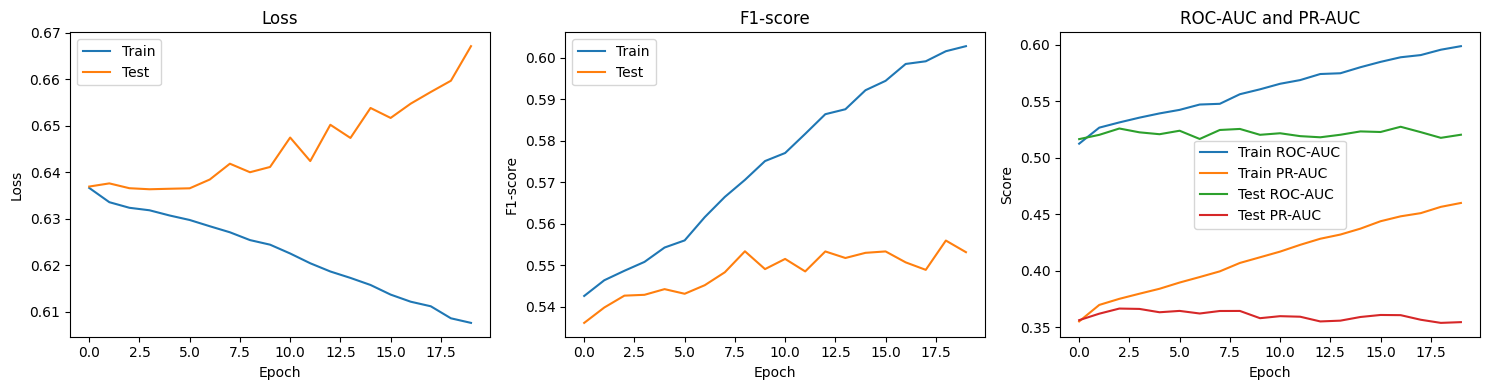

In [35]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.plot(train_loss_values, label="Train")
ax1.plot(test_loss_values, label="Test")
ax1.legend()

ax2.set_title("F1-score")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("F1-score")
ax2.plot(train_f1_values, label="Train")
ax2.plot(test_f1_values, label="Test")
ax2.legend()

ax3.set_title("ROC-AUC and PR-AUC")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Score")
ax3.plot(train_roc_auc_values, label="Train ROC-AUC")
ax3.plot(train_pr_auc_values, label="Train PR-AUC")
ax3.plot(test_roc_auc_values, label="Test ROC-AUC")
ax3.plot(test_pr_auc_values, label="Test PR-AUC")
ax3.legend()

fig.tight_layout()
plt.show()

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
import matplotlib.pyplot as plt

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

input_size = X.shape[1]
hidden_size = 128
output_size = 2

model = MLP(input_size, hidden_size, output_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.from_numpy(X_train)
X_test = torch.from_numpy(X_test)

epochs = 50
train_loss_history = []
train_f1_history = []
train_roc_auc_history = []
train_pr_auc_history = []
test_loss_history = []
test_f1_history = []
test_roc_auc_history = []
test_pr_auc_history = []


for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        model.eval()
        train_outputs = model(X_train)
        _, train_predicted = torch.max(train_outputs, 1)
        train_f1 = f1_score(y_train, train_predicted, average='weighted')
        train_loss_history.append(loss.item())
        train_f1_history.append(train_f1)
        train_roc_auc_history.append(roc_auc_score(y_train, train_outputs[:, 1]))
        train_precision, train_recall, _ = precision_recall_curve(y_train, train_outputs[:, 1])
        train_pr_auc_history.append(auc(train_recall, train_precision))
    
    with torch.no_grad():
        model.eval()
        test_outputs = model(X_test)
        _, test_predicted = torch.max(test_outputs, 1)
        test_loss = criterion(test_outputs, y_test)
        test_f1 = f1_score(y_test, test_predicted, average='weighted')
        test_loss_history.append(test_loss.item())
        test_f1_history.append(test_f1)
        test_roc_auc = roc_auc_score(y_test, test_outputs[:, 1])
        test_roc_auc_history.append(test_roc_auc)
        test_precision, test_recall, _ = precision_recall_curve(y_test, test_outputs[:, 1])
        test_pr_auc = auc(test_recall, test_precision)
        test_pr_auc_history.append(test_pr_auc)

    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.4f}, Train F1-score: {train_f1:.4f}, Train ROC-AUC: {train_roc_auc_history[-1]:.4f}, Train PR-AUC: {train_pr_auc_history[-1]:.4f}, Test Loss: {test_loss.item():.4f}, Test F1-score: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc_history[-1]:.4f}, Test PR-AUC: {test_pr_auc_history[-1]:.4f}')

Epoch [1/50], Train Loss: 0.7079, Train F1-score: 0.5740, Train ROC-AUC: 0.5078, Train PR-AUC: 0.3458, Test Loss: 0.6852, Test F1-score: 0.5692, Test ROC-AUC: 0.4996, Test PR-AUC: 0.3450
Epoch [2/50], Train Loss: 0.6857, Train F1-score: 0.5716, Train ROC-AUC: 0.5115, Train PR-AUC: 0.3499, Test Loss: 0.6750, Test F1-score: 0.5655, Test ROC-AUC: 0.5024, Test PR-AUC: 0.3487
Epoch [3/50], Train Loss: 0.6770, Train F1-score: 0.5630, Train ROC-AUC: 0.5128, Train PR-AUC: 0.3516, Test Loss: 0.6657, Test F1-score: 0.5579, Test ROC-AUC: 0.5044, Test PR-AUC: 0.3504
Epoch [4/50], Train Loss: 0.6679, Train F1-score: 0.5555, Train ROC-AUC: 0.5131, Train PR-AUC: 0.3527, Test Loss: 0.6575, Test F1-score: 0.5523, Test ROC-AUC: 0.5056, Test PR-AUC: 0.3512
Epoch [5/50], Train Loss: 0.6591, Train F1-score: 0.5501, Train ROC-AUC: 0.5135, Train PR-AUC: 0.3535, Test Loss: 0.6510, Test F1-score: 0.5464, Test ROC-AUC: 0.5060, Test PR-AUC: 0.3514
Epoch [6/50], Train Loss: 0.6515, Train F1-score: 0.5460, Train R

Epoch [45/50], Train Loss: 0.6304, Train F1-score: 0.5521, Train ROC-AUC: 0.5367, Train PR-AUC: 0.3797, Test Loss: 0.6382, Test F1-score: 0.5421, Test ROC-AUC: 0.5122, Test PR-AUC: 0.3552
Epoch [46/50], Train Loss: 0.6302, Train F1-score: 0.5523, Train ROC-AUC: 0.5372, Train PR-AUC: 0.3806, Test Loss: 0.6381, Test F1-score: 0.5430, Test ROC-AUC: 0.5125, Test PR-AUC: 0.3557
Epoch [47/50], Train Loss: 0.6301, Train F1-score: 0.5526, Train ROC-AUC: 0.5376, Train PR-AUC: 0.3813, Test Loss: 0.6380, Test F1-score: 0.5431, Test ROC-AUC: 0.5126, Test PR-AUC: 0.3561
Epoch [48/50], Train Loss: 0.6300, Train F1-score: 0.5528, Train ROC-AUC: 0.5380, Train PR-AUC: 0.3818, Test Loss: 0.6379, Test F1-score: 0.5433, Test ROC-AUC: 0.5126, Test PR-AUC: 0.3563
Epoch [49/50], Train Loss: 0.6298, Train F1-score: 0.5527, Train ROC-AUC: 0.5385, Train PR-AUC: 0.3821, Test Loss: 0.6378, Test F1-score: 0.5431, Test ROC-AUC: 0.5126, Test PR-AUC: 0.3565
Epoch [50/50], Train Loss: 0.6297, Train F1-score: 0.5526, T

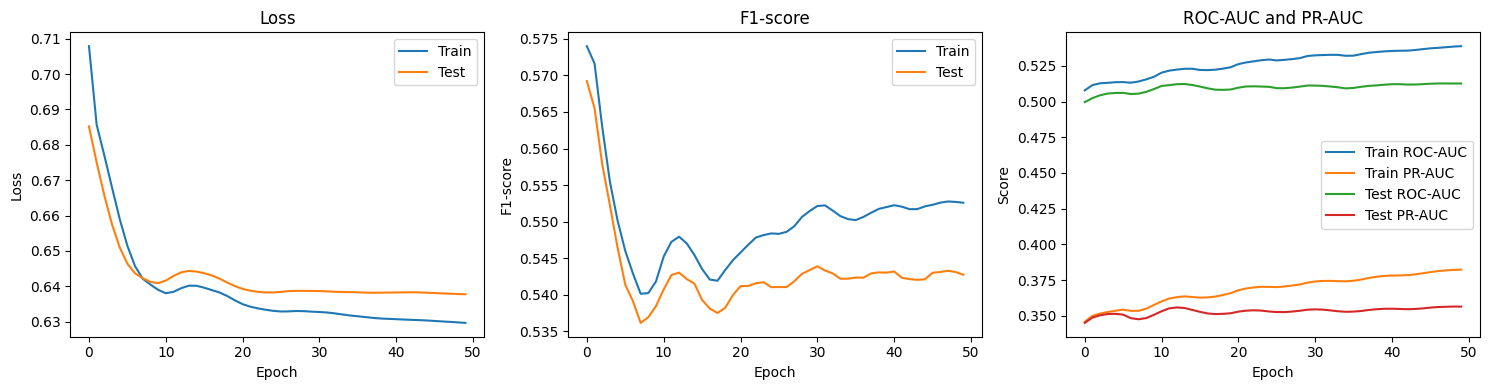

In [37]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.plot(train_loss_history, label="Train")
ax1.plot(test_loss_history, label="Test")
ax1.legend()

ax2.set_title("F1-score")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("F1-score")
ax2.plot(train_f1_history, label="Train")
ax2.plot(test_f1_history, label="Test")
ax2.legend()

ax3.set_title("ROC-AUC and PR-AUC")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Score")
ax3.plot(train_roc_auc_history, label="Train ROC-AUC")
ax3.plot(train_pr_auc_history, label="Train PR-AUC")
ax3.plot(test_roc_auc_history, label="Test ROC-AUC")
ax3.plot(test_pr_auc_history, label="Test PR-AUC")
ax3.legend()

fig.tight_layout()
plt.show()

In [38]:
import pandas as pd
import torch
array = X
df_x = pd.DataFrame(array, columns=feature_names)

In [39]:
df_x

,Histone_H3K36me3,Histone_H4K20me3,Histone_H3K36me2,Histone_H4K20me1,Histone_H3K27ac,Histone_H3K9me3,Histone_H3K9me2,Histone_H2A.Z,Histone_H3K18ac,Histone_CENPA,...,TFs_XRCC6,TFs_YAP1,TFs_YWHAZ,TFs_YY1,TFs_ZBTB7A,TFs_ZFX,TFs_ZFY,TFs_ZMYND11,TFs_ZMYND8,TFs_ZNF711
0,-0.165181,-0.071259,-0.051224,-0.047049,-0.421279,2.938125,-0.06327,-0.251446,-0.187933,-0.043356,...,-0.097383,-0.079076,-0.114279,-0.098444,-0.098107,-0.12853,-0.083459,-0.052834,-0.110294,-0.077032
1,-0.165181,-0.071259,-0.051224,-0.047049,-0.246107,-0.171672,-0.06327,2.810243,-0.187933,-0.043356,...,-0.097383,-0.079076,-0.114279,-0.098444,-0.098107,-0.12853,-0.083459,-0.052834,-0.110294,-0.077032
2,-0.165181,-0.071259,-0.051224,-0.047049,-0.421279,-0.171672,-0.06327,-0.251446,-0.187933,-0.043356,...,-0.097383,-0.079076,-0.114279,-0.098444,-0.098107,-0.12853,-0.083459,-0.052834,-0.110294,-0.077032
3,-0.165181,-0.071259,-0.051224,-0.047049,-0.175585,-0.171672,-0.06327,-0.251446,-0.187933,-0.043356,...,-0.097383,-0.079076,-0.114279,-0.098444,-0.098107,-0.12853,-0.083459,-0.052834,-0.110294,-0.077032
4,-0.165181,-0.071259,-0.051224,-0.047049,-0.295269,-0.171672,-0.06327,-0.251446,-0.187933,-0.043356,...,-0.097383,-0.079076,-0.114279,-0.098444,-0.098107,-0.12853,-0.083459,-0.052834,-0.110294,-0.077032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80794,-0.165181,-0.071259,-0.051224,-0.047049,-0.287188,-0.171672,-0.06327,-0.251446,-0.187933,-0.043356,...,-0.097383,-0.079076,-0.114279,-0.098444,-0.098107,-0.12853,-0.083459,-0.052834,-0.110294,-0.077032
80795,-0.165181,-0.071259,-0.051224,-0.047049,0.114378,-0.171672,-0.06327,-0.251446,-0.187933,-0.043356,...,-0.097383,-0.079076,-0.114279,-0.098444,-0.098107,-0.12853,-0.083459,-0.052834,-0.110294,-0.077032
80796,-0.165181,-0.071259,-0.051224,-0.047049,-0.421279,-0.171672,-0.06327,-0.251446,-0.187933,-0.043356,...,-0.097383,-0.079076,-0.114279,-0.098444,-0.098107,-0.12853,-0.083459,-0.052834,-0.110294,-0.077032
80797,-0.165181,-0.071259,-0.051224,-0.047049,-0.359035,-0.171672,-0.06327,-0.251446,-0.187933,-0.043356,...,-0.097383,-0.079076,-0.114279,-0.098444,-0.098107,-0.12853,-0.083459,-0.052834,-0.110294,-0.077032


In [40]:
array = y.numpy()
df_y = pd.DataFrame(array, columns=['target'])

In [41]:
df_y

,target
0,0
1,0
2,0
3,0
4,1
...,...
80794,1
80795,1
80796,1
80797,0


In [42]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(df_x, df_y)
importances = rf.feature_importances_
for feature, importance in zip(df_x.columns, importances):
    print(f'{feature}: {importance}')

/tmp/ipykernel_29655/162895947.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(df_x, df_y)


Histone_H3K36me3: 0.014983857922525524
Histone_H4K20me3: 0.002065820996193904
Histone_H3K36me2: 0.000415666857538482
Histone_H4K20me1: 0.0003446322080864501
Histone_H3K27ac: 0.052795686426902605
Histone_H3K9me3: 0.019052087570420255
Histone_H3K9me2: 0.0011269646923787917
Histone_H2A.Z: 0.016213721156910818
Histone_H3K18ac: 0.003809901237547292
Histone_CENPA: 0.00013512874334098088
Histone_H3: 0.00035283034698163846
Histone_H4K5K8K12ac: 0.000974012462670424
Histone_H1: 2.720189723027058e-05
Histone_H3K79me2: 0.0022380358974571804
Histone_H4K12me1: 3.0511388303768317e-05
Histone_H3K9K14ac: 0.0013565830750113326
Histone_H3T6ph: 4.2804723311336036e-05
Histone_H4ac: 0.0009154158104649221
Histone_H3T11ph: 1.9179049701623118e-05
Histone_H3K9ac: 0.00302848439886323
Histone_H3K4me2: 0.02365993898362183
Histone_H3K4me3: 0.01810325445929663
Histone_H3K27me3: 0.07323582892874053
Histone_H2A.ZK4K7K11ac: 0.005619280327535843
Histone_H3K4me1: 0.041623402472930705
Histone_H2BK15ac: 0.00137308736168302

In [43]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, precision_recall_curve, auc


X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=42)
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)

print(f'F1-score: {f1:.4f}')
print(f'ROC-AUC: {roc_auc:.4f}')
print(f'PR-AUC: {pr_auc:.4f}')


/tmp/ipykernel_29655/4292731798.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


F1-score: 0.1888
ROC-AUC: 0.4823
PR-AUC: 0.3578


              feature  importance
40             TFs_AR    0.089924
87          TFs_FOXA1    0.080870
22   Histone_H3K27me3    0.073835
4     Histone_H3K27ac    0.052449
24    Histone_H3K4me1    0.042351
..                ...         ...
89          TFs_FOXM1    0.000010
180         TFs_WDHD1    0.000009
115         TFs_MED12    0.000007
160       TFs_SMARCB1    0.000007
91           TFs_FXR1    0.000005

[193 rows x 2 columns]


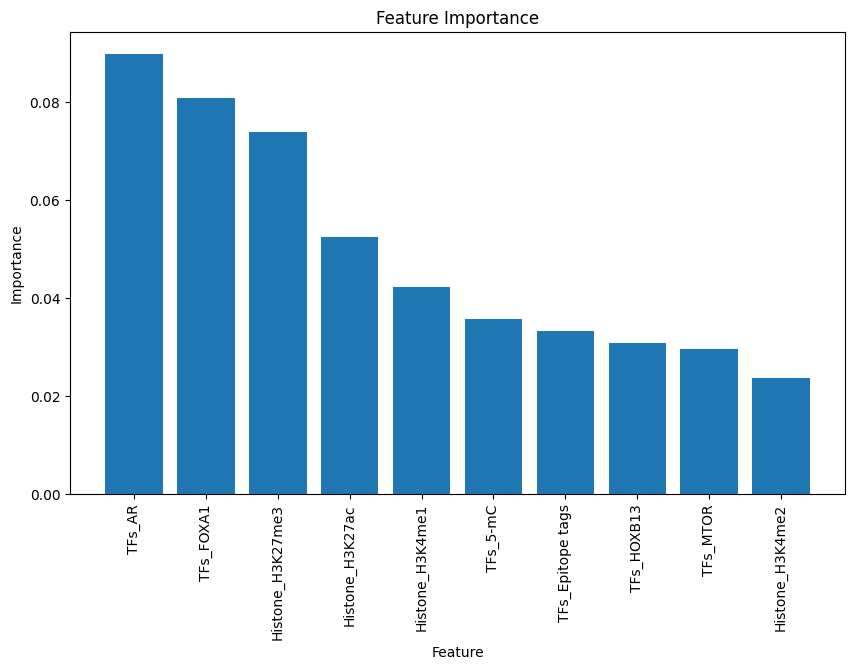

In [44]:
import pandas as pd
import matplotlib.pyplot as plt


importances = rf.feature_importances_
df_importances = pd.DataFrame({'feature': df_x.columns, 'importance': importances})
df_importances = df_importances.sort_values('importance', ascending=False)
print(df_importances)
plt.figure(figsize=(10, 6))
plt.bar(df_importances['feature'][:10], df_importances['importance'][:10])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()


In [45]:
import catboost as cb
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=42)
model = cb.CatBoostClassifier(
    iterations=1000, 
    learning_rate=0.1,
    depth=6, 
    random_seed=42,
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred)
pr_roc = average_precision_score(y_test, y_pred)

print(f"F1: {f1}, AUC-ROC: {auc_roc}, PR-ROC: {pr_roc}")

0:	learn: 0.6817778	total: 58.9ms	remaining: 58.8s
1:	learn: 0.6725904	total: 70.7ms	remaining: 35.3s
2:	learn: 0.6651576	total: 81.6ms	remaining: 27.1s
3:	learn: 0.6591790	total: 94.2ms	remaining: 23.4s
4:	learn: 0.6542723	total: 107ms	remaining: 21.2s
5:	learn: 0.6503268	total: 119ms	remaining: 19.7s
6:	learn: 0.6470287	total: 130ms	remaining: 18.5s
7:	learn: 0.6443032	total: 142ms	remaining: 17.6s
8:	learn: 0.6422667	total: 155ms	remaining: 17.1s
9:	learn: 0.6405288	total: 167ms	remaining: 16.6s
10:	learn: 0.6390603	total: 179ms	remaining: 16.1s
11:	learn: 0.6378942	total: 190ms	remaining: 15.7s
12:	learn: 0.6369716	total: 203ms	remaining: 15.4s
13:	learn: 0.6360421	total: 215ms	remaining: 15.2s
14:	learn: 0.6354244	total: 228ms	remaining: 14.9s
15:	learn: 0.6348272	total: 240ms	remaining: 14.7s
16:	learn: 0.6343290	total: 252ms	remaining: 14.6s
17:	learn: 0.6339859	total: 264ms	remaining: 14.4s
18:	learn: 0.6336564	total: 276ms	remaining: 14.2s
19:	learn: 0.6333495	total: 287ms	rem

161:	learn: 0.6193056	total: 2.1s	remaining: 10.9s
162:	learn: 0.6192081	total: 2.11s	remaining: 10.9s
163:	learn: 0.6191292	total: 2.13s	remaining: 10.8s
164:	learn: 0.6190240	total: 2.14s	remaining: 10.8s
165:	learn: 0.6189066	total: 2.15s	remaining: 10.8s
166:	learn: 0.6188155	total: 2.17s	remaining: 10.8s
167:	learn: 0.6187219	total: 2.18s	remaining: 10.8s
168:	learn: 0.6186263	total: 2.19s	remaining: 10.8s
169:	learn: 0.6185285	total: 2.2s	remaining: 10.8s
170:	learn: 0.6184632	total: 2.22s	remaining: 10.8s
171:	learn: 0.6183534	total: 2.23s	remaining: 10.7s
172:	learn: 0.6182871	total: 2.24s	remaining: 10.7s
173:	learn: 0.6182161	total: 2.25s	remaining: 10.7s
174:	learn: 0.6180935	total: 2.27s	remaining: 10.7s
175:	learn: 0.6179941	total: 2.28s	remaining: 10.7s
176:	learn: 0.6179288	total: 2.29s	remaining: 10.7s
177:	learn: 0.6178006	total: 2.31s	remaining: 10.6s
178:	learn: 0.6176838	total: 2.32s	remaining: 10.6s
179:	learn: 0.6175948	total: 2.33s	remaining: 10.6s
180:	learn: 0.

321:	learn: 0.6054200	total: 4.16s	remaining: 8.76s
322:	learn: 0.6053626	total: 4.17s	remaining: 8.74s
323:	learn: 0.6053147	total: 4.18s	remaining: 8.73s
324:	learn: 0.6052373	total: 4.2s	remaining: 8.72s
325:	learn: 0.6051685	total: 4.21s	remaining: 8.7s
326:	learn: 0.6051249	total: 4.22s	remaining: 8.69s
327:	learn: 0.6051108	total: 4.23s	remaining: 8.67s
328:	learn: 0.6050510	total: 4.25s	remaining: 8.66s
329:	learn: 0.6050005	total: 4.26s	remaining: 8.65s
330:	learn: 0.6049428	total: 4.27s	remaining: 8.63s
331:	learn: 0.6049008	total: 4.28s	remaining: 8.62s
332:	learn: 0.6048458	total: 4.3s	remaining: 8.61s
333:	learn: 0.6047563	total: 4.31s	remaining: 8.59s
334:	learn: 0.6046816	total: 4.32s	remaining: 8.58s
335:	learn: 0.6045837	total: 4.33s	remaining: 8.57s
336:	learn: 0.6045130	total: 4.35s	remaining: 8.55s
337:	learn: 0.6044267	total: 4.36s	remaining: 8.54s
338:	learn: 0.6043301	total: 4.37s	remaining: 8.53s
339:	learn: 0.6042620	total: 4.39s	remaining: 8.51s
340:	learn: 0.6

480:	learn: 0.5947030	total: 6.21s	remaining: 6.71s
481:	learn: 0.5946469	total: 6.23s	remaining: 6.69s
482:	learn: 0.5945886	total: 6.24s	remaining: 6.68s
483:	learn: 0.5945240	total: 6.25s	remaining: 6.67s
484:	learn: 0.5944679	total: 6.27s	remaining: 6.66s
485:	learn: 0.5944222	total: 6.28s	remaining: 6.64s
486:	learn: 0.5943580	total: 6.29s	remaining: 6.63s
487:	learn: 0.5942638	total: 6.31s	remaining: 6.62s
488:	learn: 0.5942030	total: 6.32s	remaining: 6.6s
489:	learn: 0.5941755	total: 6.33s	remaining: 6.59s
490:	learn: 0.5940818	total: 6.34s	remaining: 6.58s
491:	learn: 0.5940337	total: 6.36s	remaining: 6.56s
492:	learn: 0.5940010	total: 6.37s	remaining: 6.55s
493:	learn: 0.5939559	total: 6.38s	remaining: 6.54s
494:	learn: 0.5939201	total: 6.39s	remaining: 6.52s
495:	learn: 0.5938114	total: 6.41s	remaining: 6.51s
496:	learn: 0.5937726	total: 6.42s	remaining: 6.5s
497:	learn: 0.5936733	total: 6.43s	remaining: 6.49s
498:	learn: 0.5936344	total: 6.45s	remaining: 6.47s
499:	learn: 0.

639:	learn: 0.5857173	total: 8.25s	remaining: 4.64s
640:	learn: 0.5856871	total: 8.26s	remaining: 4.63s
641:	learn: 0.5856179	total: 8.28s	remaining: 4.62s
642:	learn: 0.5855635	total: 8.29s	remaining: 4.6s
643:	learn: 0.5855121	total: 8.3s	remaining: 4.59s
644:	learn: 0.5854895	total: 8.31s	remaining: 4.58s
645:	learn: 0.5854868	total: 8.33s	remaining: 4.56s
646:	learn: 0.5853654	total: 8.34s	remaining: 4.55s
647:	learn: 0.5853131	total: 8.35s	remaining: 4.54s
648:	learn: 0.5852717	total: 8.37s	remaining: 4.52s
649:	learn: 0.5851875	total: 8.38s	remaining: 4.51s
650:	learn: 0.5851680	total: 8.39s	remaining: 4.5s
651:	learn: 0.5851096	total: 8.4s	remaining: 4.49s
652:	learn: 0.5850418	total: 8.42s	remaining: 4.47s
653:	learn: 0.5850404	total: 8.43s	remaining: 4.46s
654:	learn: 0.5849702	total: 8.44s	remaining: 4.45s
655:	learn: 0.5848961	total: 8.45s	remaining: 4.43s
656:	learn: 0.5848556	total: 8.47s	remaining: 4.42s
657:	learn: 0.5847714	total: 8.48s	remaining: 4.41s
658:	learn: 0.58

799:	learn: 0.5779624	total: 10.3s	remaining: 2.58s
800:	learn: 0.5778933	total: 10.3s	remaining: 2.56s
801:	learn: 0.5778143	total: 10.3s	remaining: 2.55s
802:	learn: 0.5777593	total: 10.3s	remaining: 2.54s
803:	learn: 0.5777091	total: 10.4s	remaining: 2.52s
804:	learn: 0.5776452	total: 10.4s	remaining: 2.51s
805:	learn: 0.5776062	total: 10.4s	remaining: 2.5s
806:	learn: 0.5775531	total: 10.4s	remaining: 2.49s
807:	learn: 0.5774465	total: 10.4s	remaining: 2.47s
808:	learn: 0.5774186	total: 10.4s	remaining: 2.46s
809:	learn: 0.5773656	total: 10.4s	remaining: 2.45s
810:	learn: 0.5773253	total: 10.4s	remaining: 2.44s
811:	learn: 0.5772632	total: 10.5s	remaining: 2.42s
812:	learn: 0.5771751	total: 10.5s	remaining: 2.41s
813:	learn: 0.5770956	total: 10.5s	remaining: 2.4s
814:	learn: 0.5770429	total: 10.5s	remaining: 2.38s
815:	learn: 0.5769763	total: 10.5s	remaining: 2.37s
816:	learn: 0.5769273	total: 10.5s	remaining: 2.36s
817:	learn: 0.5768652	total: 10.5s	remaining: 2.35s
818:	learn: 0.

958:	learn: 0.5712671	total: 12.3s	remaining: 528ms
959:	learn: 0.5712217	total: 12.4s	remaining: 515ms
960:	learn: 0.5711605	total: 12.4s	remaining: 502ms
961:	learn: 0.5711300	total: 12.4s	remaining: 489ms
962:	learn: 0.5710423	total: 12.4s	remaining: 476ms
963:	learn: 0.5709947	total: 12.4s	remaining: 463ms
964:	learn: 0.5709549	total: 12.4s	remaining: 450ms
965:	learn: 0.5709256	total: 12.4s	remaining: 438ms
966:	learn: 0.5708985	total: 12.4s	remaining: 425ms
967:	learn: 0.5708633	total: 12.5s	remaining: 412ms
968:	learn: 0.5708039	total: 12.5s	remaining: 399ms
969:	learn: 0.5707483	total: 12.5s	remaining: 386ms
970:	learn: 0.5707189	total: 12.5s	remaining: 373ms
971:	learn: 0.5706651	total: 12.5s	remaining: 360ms
972:	learn: 0.5706074	total: 12.5s	remaining: 347ms
973:	learn: 0.5705704	total: 12.5s	remaining: 335ms
974:	learn: 0.5705114	total: 12.5s	remaining: 322ms
975:	learn: 0.5704668	total: 12.6s	remaining: 309ms
976:	learn: 0.5704508	total: 12.6s	remaining: 296ms
977:	learn: 

In [46]:
feature_importances = model.feature_importances_
for feature_name, feature_importance in zip(df_x.columns, feature_importances):
    print(f"{feature_name}: {feature_importance}")

Histone_H3K36me3: 1.0867916006988674
Histone_H4K20me3: 0.30959091741059713
Histone_H3K36me2: 0.03215579849962594
Histone_H4K20me1: 0.04040110151852666
Histone_H3K27ac: 3.2225020512062
Histone_H3K9me3: 1.2506080781073416
Histone_H3K9me2: 0.2759332946677863
Histone_H2A.Z: 1.2839792947976523
Histone_H3K18ac: 0.5506397119357885
Histone_CENPA: 0.017358128890871464
Histone_H3: 0.08915663847951057
Histone_H4K5K8K12ac: 0.14354172309607194
Histone_H1: 0.00947946396034722
Histone_H3K79me2: 0.20445167026666883
Histone_H4K12me1: 0.015168197725598407
Histone_H3K9K14ac: 0.2245590869955931
Histone_H3T6ph: 0.010460624499584157
Histone_H4ac: 0.10905682112374442
Histone_H3T11ph: 0.0
Histone_H3K9ac: 0.7070517581890516
Histone_H3K4me2: 2.78447993331388
Histone_H3K4me3: 2.243728970628718
Histone_H3K27me3: 1.5269194963319728
Histone_H2A.ZK4K7K11ac: 0.9173027364715068
Histone_H3K4me1: 3.5977505198948574
Histone_H2BK15ac: 0.46854953662021875
Histone_H3K14ac: 0.16520897562514425
Histone_H4K5ac: 0.9381132842461

             feature  importance
40            TFs_AR    4.672753
87         TFs_FOXA1    3.753076
24   Histone_H3K4me1    3.597751
4    Histone_H3K27ac    3.222502
100       TFs_HOXB13    2.903368
..               ...         ...
111         TFs_LMNA    0.000000
73          TFs_ELK4    0.000000
51         TFs_CCNT1    0.000000
89         TFs_FOXM1    0.000000
18   Histone_H3T11ph    0.000000

[193 rows x 2 columns]


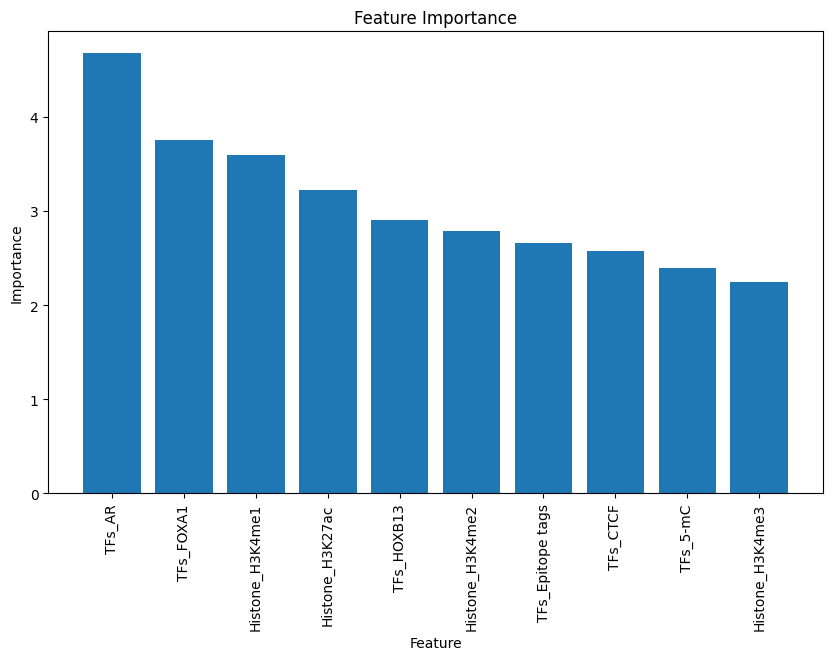

In [47]:
importances = feature_importances
df_importances = pd.DataFrame({'feature': df_x.columns, 'importance': importances})
df_importances = df_importances.sort_values('importance', ascending=False)
print(df_importances)
plt.figure(figsize=(10, 6))
plt.bar(df_importances['feature'][:10], df_importances['importance'][:10])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()
